In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sonnia.processing import Processing
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Reshape, Activation, Input, Lambda
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Concatenate
from sklearn.decomposition import PCA

from keras import backend as K
import keras
from keras import losses
from tensorflow.python.framework.ops import disable_eager_execution
from vampire_custom_keras import BetaWarmup, EmbedViaMatrix
from keras import regularizers
from keras.layers.core import Dropout

disable_eager_execution()

# Select dataset

In [4]:
df = pd.read_csv('peptide-detail-ci_filtered_aligned_merged.csv')
df["Amino Acids 1"] = df["Amino Acids"].apply(lambda x: x.split(",")[0])
df

CDR3               CDR3_al  \
0          CASSAQGTGDRGYTF  CASSA-----QGTGDRGYTF   
1         CASSLVATGNTGELFF  CASSL----VATGNTGELFF   
2             CALKVGADTQYF  CALKV--------GADTQYF   
3       CASSLWASGRGGTGELFF  CASSLW--ASGRGGTGELFF   
4         CASSLLGWEQLDEQFF  CASSL----LGWEQLDEQFF   
...                    ...                   ...   
236340       CASSSGPQETQYF  CASSS-------GPQETQYF   
236341      CASSKRDSQETQYF  CASSK------RDSQETQYF   
236342     CASSQLPGQGKVQYF  CASSQ-----LPGQGKVQYF   
236343        CASSPGDNEQFF  CASSP--------GDNEQFF   
236344       CASSVGDPDTQYF  CASSV-------GDPDTQYF   

                                         tokenized_smiles  \
0            [12, 16, 34, 34, 31, 31, 31, 31, 31, 27, 13]   
1        [12, 16, 34, 34, 31, 31, 31, 31, 23, 27, 27, 13]   
2        [12, 16, 31, 31, 31, 31, 31, 31, 31, 31, 27, 13]   
3                [12, 16, 34, 34, 31, 31, 34, 27, 27, 13]   
4            [12, 16, 34, 34, 31, 31, 31, 31, 27, 27, 13]   
...                                                   ...   
236340  [12, 16, 34, 34, 34, 31, 31, 31, 31, 31, 31, 3...   
236341  [12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...   
236342   [12, 16, 34, 34, 31, 31, 31, 31, 31, 45, 27, 13]   
236343  [12, 16, 34, 34, 45, 31, 31, 31, 31, 31, 31, 3...   
236344  [12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 31, 4...   

                                 TCR BioIdentity  \
0          CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02   
1         CASSLVATGNTGELFF+TCRBV07-09+TCRBJ02-02   
2             CALKVGADTQYF+TCRBV30-01+TCRBJ02-03   
3       CASSLWASGRGGTGELFF+TCRBV27-01+TCRBJ02-02   
4         CASSLLGWEQLDEQFF+TCRBV27-01+TCRBJ02-01   
...                                          ...   
236340       CASSSGPQETQYF+TCRBV07-09+TCRBJ02-05   
236341      CASSKRDSQETQYF+TCRBV07-09+TCRBJ02-05   
236342     CASSQLPGQGKVQYF+TCRBV04-01+TCRBJ02-07   
236343        CASSPGDNEQFF+TCRBV09-01+TCRBJ02-01   
236344       CASSVGDPDTQYF+TCRBV09-01+TCRBJ02-03   

                                  TCR Nucleotide Sequence Experiment  \
0       GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...      eAV93   
1       CGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCT...      eOX56   
2       CTGAGTTCTAAGAAGCTCCTTCTCAGTGACTCTGGCTTCTATCTCT...     eQD124   
3       AGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTTTATGGG...      eAV93   
4       TCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTT...      eMR16   
...                                                   ...        ...   
236340  GAGATCCAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTG...      eAV88   
236341  ATCCAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCA...     eDH105   
236342  CACGCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCGCCAGCA...      eAV93   
236343  CTAAACCTGAGCTCTCTGGAGCTGGGGGACTCAGCTTTGTATTTCT...     eEE224   
236344  AACCTGAGCTCTCTGGAGCTGGGGGACTCAGCTTTGTATTTCTGTG...      eAV88   

                       ORF Coverage                              Amino Acids  \
0       ORF1ab,surface glycoprotein  ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK   
1       ORF1ab,surface glycoprotein  ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK   
2       ORF1ab,surface glycoprotein  ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK   
3       ORF1ab,surface glycoprotein  ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK   
4       ORF1ab,surface glycoprotein  ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK   
...                             ...                                      ...   
236340                        ORF10                     AQVDVVNFNL,NYIAQVDVV   
236341                        ORF10                     AQVDVVNFNL,NYIAQVDVV   
236342                        ORF10                     AQVDVVNFNL,NYIAQVDVV   
236343                        ORF10                     AQVDVVNFNL,NYIAQVDVV   
236344                        ORF10                     AQVDVVNFNL,NYIAQVDVV   

        Start Index in Genome  End Index in Genome      v_gene      j_gene  \
0                         533                24073  TCRBV27-01  TCRBJ01-02   
1                         533                24073  TCRBV

In [5]:
df

CDR3               CDR3_al  \
0          CASSAQGTGDRGYTF  CASSA-----QGTGDRGYTF   
1         CASSLVATGNTGELFF  CASSL----VATGNTGELFF   
2             CALKVGADTQYF  CALKV--------GADTQYF   
3       CASSLWASGRGGTGELFF  CASSLW--ASGRGGTGELFF   
4         CASSLLGWEQLDEQFF  CASSL----LGWEQLDEQFF   
...                    ...                   ...   
236340       CASSSGPQETQYF  CASSS-------GPQETQYF   
236341      CASSKRDSQETQYF  CASSK------RDSQETQYF   
236342     CASSQLPGQGKVQYF  CASSQ-----LPGQGKVQYF   
236343        CASSPGDNEQFF  CASSP--------GDNEQFF   
236344       CASSVGDPDTQYF  CASSV-------GDPDTQYF   

                                         tokenized_smiles  \
0            [12, 16, 34, 34, 31, 31, 31, 31, 31, 27, 13]   
1        [12, 16, 34, 34, 31, 31, 31, 31, 23, 27, 27, 13]   
2        [12, 16, 31, 31, 31, 31, 31, 31, 31, 31, 27, 13]   
3                [12, 16, 34, 34, 31, 31, 34, 27, 27, 13]   
4            [12, 16, 34, 34, 31, 31, 31, 31, 27, 27, 13]   
...                                                   ...   
236340  [12, 16, 34, 34, 34, 31, 31, 31, 31, 31, 31, 3...   
236341  [12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...   
236342   [12, 16, 34, 34, 31, 31, 31, 31, 31, 45, 27, 13]   
236343  [12, 16, 34, 34, 45, 31, 31, 31, 31, 31, 31, 3...   
236344  [12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 31, 4...   

                                 TCR BioIdentity  \
0          CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02   
1         CASSLVATGNTGELFF+TCRBV07-09+TCRBJ02-02   
2             CALKVGADTQYF+TCRBV30-01+TCRBJ02-03   
3       CASSLWASGRGGTGELFF+TCRBV27-01+TCRBJ02-02   
4         CASSLLGWEQLDEQFF+TCRBV27-01+TCRBJ02-01   
...                                          ...   
236340       CASSSGPQETQYF+TCRBV07-09+TCRBJ02-05   
236341      CASSKRDSQETQYF+TCRBV07-09+TCRBJ02-05   
236342     CASSQLPGQGKVQYF+TCRBV04-01+TCRBJ02-07   
236343        CASSPGDNEQFF+TCRBV09-01+TCRBJ02-01   
236344       CASSVGDPDTQYF+TCRBV09-01+TCRBJ02-03   

                                  TCR Nucleotide Sequence Experiment  \
0       GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...      eAV93   
1       CGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCT...      eOX56   
2       CTGAGTTCTAAGAAGCTCCTTCTCAGTGACTCTGGCTTCTATCTCT...     eQD124   
3       AGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTTTATGGG...      eAV93   
4       TCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTT...      eMR16   
...                                                   ...        ...   
236340  GAGATCCAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTG...      eAV88   
236341  ATCCAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCA...     eDH105   
236342  CACGCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCGCCAGCA...      eAV93   
236343  CTAAACCTGAGCTCTCTGGAGCTGGGGGACTCAGCTTTGTATTTCT...     eEE224   
236344  AACCTGAGCTCTCTGGAGCTGGGGGACTCAGCTTTGTATTTCTGTG...      eAV88   

                       ORF Coverage                              Amino Acids  \
0       ORF1ab,surface glycoprotein  ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK   
1       ORF1ab,surface glycoprotein  ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK   
2       ORF1ab,surface glycoprotein  ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK   
3       ORF1ab,surface glycoprotein  ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK   
4       ORF1ab,surface glycoprotein  ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK   
...                             ...                                      ...   
236340                        ORF10                     AQVDVVNFNL,NYIAQVDVV   
236341                        ORF10                     AQVDVVNFNL,NYIAQVDVV   
236342                        ORF10                     AQVDVVNFNL,NYIAQVDVV   
236343                        ORF10                     AQVDVVNFNL,NYIAQVDVV   
236344                        ORF10                     AQVDVVNFNL,NYIAQVDVV   

        Start Index in Genome  End Index in Genome      v_gene      j_gene  \
0                         533                24073  TCRBV27-01  TCRBJ01-02   
1                         533                24073  TCRBV

In [6]:

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

aa = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q","R", "S", "T", "V", "W", "Y", "-"]

# integer encode
label_encoder = LabelEncoder()
y_encoder =LabelEncoder()
y_encoder = y_encoder.fit(df['Amino Acids'].unique())
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = label_encoder.fit_transform(aa)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit(integer_encoded)


/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [7]:
one_hot_status = True
col_one_hot = []
col_integer = []
y_labels = []
for k in tqdm(df.index):
    integer_encoded = label_encoder.transform(list(df.loc[k,"CDR3_al"]))
    col_integer.append(integer_encoded)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    if one_hot_status:
        onehot_encoded = onehot_encoder.transform(integer_encoded)
        col_one_hot.append(onehot_encoded)
    y_label = y_encoder.transform([df.loc[k,"Amino Acids"]])
    y_labels.append(y_label)
    

  0%|          | 0/236345 [00:00<?, ?it/s]

In [ ]:
# save one hot encoder
with open('./encoders/onehot_encoder.pkl', 'wb') as handle:
    pickle.dump(onehot_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [8]:
y_labels = [int(y) for y in y_labels]
if one_hot_status:
    df["CDR3_al_one_hot"] = col_one_hot
df["CDR3_al_integer"] = col_integer
df["label"] = y_labels

In [9]:
v_labels = []
v_encoder = LabelEncoder()
v_encoder_one_hot = OneHotEncoder(sparse=False)
v_encoder = v_encoder.fit(df['v_gene'].unique())
v_encoder_one_hot = v_encoder_one_hot.fit(v_encoder.transform(df['v_gene'].unique()).reshape(-1,1))
for k in tqdm(df.index):
    v_label = v_encoder.transform([df.loc[k,"v_gene"]])
    v_label = v_encoder_one_hot.transform(v_label.reshape(-1,1))
    v_labels.append(v_label)
df["v_gene_one_hot"] = v_labels

j_labels = []
j_encoder = LabelEncoder()
j_encoder_one_hot = OneHotEncoder(sparse=False)
j_encoder = j_encoder.fit(df['j_gene'].unique())
j_encoder_one_hot = j_encoder_one_hot.fit(j_encoder.transform(df['j_gene'].unique()).reshape(-1,1))
for k in tqdm(df.index):
    j_label = j_encoder.transform([df.loc[k,"j_gene"]])
    j_label = j_encoder_one_hot.transform(j_label.reshape(-1,1))
    j_labels.append(j_label)
df["j_gene_one_hot"] = j_labels

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


  0%|          | 0/236345 [00:00<?, ?it/s]

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


  0%|          | 0/236345 [00:00<?, ?it/s]

In [10]:
len_j_gene = len(j_encoder.classes_)
len_v_gene = len(v_encoder.classes_)
print(len_j_gene, len_v_gene)

13 54


In [11]:
df = df.sample(frac=1).reset_index(drop=True)
data = df[['CDR3_al_one_hot', 'v_gene_one_hot', 'j_gene_one_hot']]
data["v_gene_one_hot"]  = data["v_gene_one_hot"].apply(lambda x: x.reshape(len_v_gene,))
data["j_gene_one_hot"]  = data["j_gene_one_hot"].apply(lambda x: x.reshape(len_j_gene,))
data = [np.stack(col.values) for _, col in data.items()]
#X_train = tf.constant(df["CDR3"].to_numpy())
#X_train_v_gene = tf.constant(df["v_gene"].to_numpy())
#X_train_j_gene = tf.constant(df["j_gene"].to_numpy())
X_train = data

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_88778/652920261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["v_gene_one_hot"]  = data["v_gene_one_hot"].apply(lambda x: x.reshape(len_v_gene,))
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_88778/652920261.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["j_gene_one_hot"]  = data["j_gene_one_hot"].apply(lambda x: x.reshape(len_j_gene,))


In [12]:
X_train[2].shape

(236345, 13)

In [13]:
def build(params):

    beta = K.variable(params['beta'])

    def sampling(args):
        """
        This function draws a sample from the multivariate normal defined by
        the latent variables.
        """
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(params['batch_size'], params['latent_dim']), mean=0.0, stddev=1.0)
        print(epsilon.shape)
        # Reparameterization trick!
        return (z_mean + K.exp(z_log_var / 2) * epsilon)

    def vae_cdr3_loss(io_encoder, io_decoder):
        """
        The loss function is the sum of the cross-entropy and KL divergence. KL
        gets a weight of beta.
        """
        # Here we multiply by the number of sites, so that we have a
        # total loss across the sites rather than a mean loss.
        xent_loss = params['max_cdr3_len'] * K.mean(losses.categorical_crossentropy(io_encoder, io_decoder))
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        kl_loss *= beta
        return (xent_loss + kl_loss)

    # Input:
    cdr3_input_shape = (params['max_cdr3_len'], params['n_aas'])
    cdr3_input = Input(shape=cdr3_input_shape, name='cdr3_input')
    v_gene_input = Input(shape=(params['n_v_genes'], ), name='v_gene_input')
    j_gene_input = Input(shape=(params['n_j_genes'], ), name='j_gene_input')

    # Encoding layers:
    cdr3_embedding = EmbedViaMatrix(params['aa_embedding_dim'], name='cdr3_embedding')(cdr3_input)
    cdr3_embedding_flat = Reshape([params['aa_embedding_dim'] * params['max_cdr3_len']],
                                  name='cdr3_embedding_flat')(cdr3_embedding)
    v_gene_embedding = Dense(params['v_gene_embedding_dim'], name='v_gene_embedding')(v_gene_input)
    j_gene_embedding = Dense(params['j_gene_embedding_dim'], name='j_gene_embedding')(j_gene_input)
    merged_embedding = keras.layers.concatenate([cdr3_embedding_flat, v_gene_embedding, j_gene_embedding],
                                                name='merged_embedding')
    encoder_dense_1 = Dense(params['dense_nodes'], activation='elu', kernel_regularizer=regularizers.l2(0.001), name='encoder_dense_1')(merged_embedding)
    encoder_dense_2 = Dense(params['dense_nodes'], activation='elu', kernel_regularizer=regularizers.l2(0.001), name='encoder_dense_2')(encoder_dense_1)
    encoder_dense_3 = Dense(params['dense_nodes'], activation='elu', kernel_regularizer=regularizers.l2(0.001), name='encoder_dense_1')(encoder_dense_2)
    encoder_dense_4 = Dense(params['dense_nodes'], activation='elu', kernel_regularizer=regularizers.l2(0.001), name='encoder_dense_2')(encoder_dense_3)
    # Latent layers:
    z_mean = Dense(params['latent_dim'], name='z_mean')(encoder_dense_2)
    z_log_var = Dense(params['latent_dim'], name='z_log_var')(encoder_dense_2)

    # Decoding layers:
    z_l = Lambda(sampling, output_shape=(params['latent_dim'], ), name='z')
    decoder_dense_1_l = Dense(params['dense_nodes'], activation='elu', name='decoder_dense_1')
    decoder_dense_2_l = Dense(params['dense_nodes'], activation='elu', name='decoder_dense_2')
    cdr3_post_dense_flat_l = Dense(np.array(cdr3_input_shape).prod(), activation='linear', name='cdr3_post_dense_flat')
    cdr3_post_dense_reshape_l = Reshape(cdr3_input_shape, name='cdr3_post_dense')
    cdr3_output_l = Activation(activation='softmax', name='cdr3_output')
    v_gene_output_l = Dense(params['n_v_genes'], activation='softmax', name='v_gene_output')
    j_gene_output_l = Dense(params['n_j_genes'], activation='softmax', name='j_gene_output')

    post_decoder = decoder_dense_2_l(decoder_dense_1_l(z_l([z_mean, z_log_var])))
    cdr3_output = cdr3_output_l(cdr3_post_dense_reshape_l(cdr3_post_dense_flat_l(post_decoder)))
    v_gene_output = v_gene_output_l(post_decoder)
    j_gene_output = j_gene_output_l(post_decoder)

    # Define the decoder components separately so we can have it as its own model.
    z_mean_input = Input(shape=(params['latent_dim'], ))
    decoder_post_decoder = decoder_dense_2_l(decoder_dense_1_l(z_mean_input))
    decoder_cdr3_output = cdr3_output_l(cdr3_post_dense_reshape_l(cdr3_post_dense_flat_l(decoder_post_decoder)))
    decoder_v_gene_output = v_gene_output_l(decoder_post_decoder)
    decoder_j_gene_output = j_gene_output_l(decoder_post_decoder)

    encoder = Model([cdr3_input, v_gene_input, j_gene_input], [z_mean, z_log_var])
    decoder = Model(z_mean_input, [decoder_cdr3_output, decoder_v_gene_output, decoder_j_gene_output])
    vae = Model([cdr3_input, v_gene_input, j_gene_input], [cdr3_output, v_gene_output, j_gene_output])
    vae.compile(
        optimizer="adam",
        loss={
            'cdr3_output': vae_cdr3_loss,
            'v_gene_output': keras.losses.categorical_crossentropy,
            'j_gene_output': keras.losses.categorical_crossentropy,
        },
        loss_weights={
            # Keep the cdr3_output weight to be 1. The weights are relative
            # anyhow, and buried inside the vae_cdr3_loss is a beta weight that
            # determines how much weight the KL loss has. If we keep this
            # weight as 1 then we can interpret beta in a straightforward way.
            "cdr3_output": 1,
            "j_gene_output": 0.1305,
            "v_gene_output": 0.8138
        })

    callbacks = [BetaWarmup(beta, params['beta'], params['warmup_period'])]

    return {'encoder': encoder, 'decoder': decoder, 'vae': vae, 'callbacks': callbacks}

In [14]:
params = {
            "latent_dim": 50,
            "dense_nodes": 75,
            "aa_embedding_dim": 21,
            "v_gene_embedding_dim": len_v_gene,
            "j_gene_embedding_dim": len_j_gene,
            "beta": 0.2,
            "max_cdr3_len": 20,
            "n_aas": 21,
            "n_v_genes": len_v_gene,
            "n_j_genes": len_j_gene,
            "stopping_monitor": "val_loss",
            "batch_size": 50,
            "pretrains": 2,
            "warmup_period": 3,
            "epochs": 4,
            "patience": 20,
            "n_inputs" : 20,
            "v_inputs" : 54,
            "j_inputs" : 13
        }

In [15]:
res = build(params)

(50, 50)


In [16]:
print(len(df))
print("Number of classes:", len(df["label"].unique()))

236345
Number of classes: 269


In [17]:
#keep only first 47000
X_train_2 = X_train.copy()
for i in range(len(X_train)):
    X_train_2[i] = X_train[i][:236000]
print(len(X_train_2[0]))

236000


In [18]:
history = res["vae"].fit(X_train_2, X_train_2, epochs=100, batch_size=50, verbose=1, validation_split=0.2, callbacks=res["callbacks"]) 

Train on 188800 samples, validate on 47200 samples


2023-06-02 16:10:29.821318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 16:10:29.849448: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch 1/100
188450/188800 [============================>.] - ETA: 0s - loss: 13.5904 - cdr3_output_loss: 12.1848 - v_gene_output_loss: 1.4313 - j_gene_output_loss: 0.3443

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


188800/188800 [==============================] - 9s 50us/sample - loss: 13.5833 - cdr3_output_loss: 12.1787 - v_gene_output_loss: 1.4301 - j_gene_output_loss: 0.3440 - val_loss: 10.2099 - val_cdr3_output_loss: 9.3323 - val_v_gene_output_loss: 0.8290 - val_j_gene_output_loss: 0.1482
Epoch 2/100
188800/188800 [==============================] - 9s 48us/sample - loss: 3.4634 - cdr3_output_loss: 2.9995 - v_gene_output_loss: 0.3065 - j_gene_output_loss: 0.0765 - val_loss: 2.4548 - val_cdr3_output_loss: 2.1014 - val_v_gene_output_loss: 0.1786 - val_j_gene_output_loss: 0.0579
Epoch 3/100
188800/188800 [==============================] - 9s 49us/sample - loss: 5.0696 - cdr3_output_loss: 4.6565 - v_gene_output_loss: 0.2683 - j_gene_output_loss: 0.0781 - val_loss: 4.6125 - val_cdr3_output_loss: 4.2495 - val_v_gene_output_loss: 0.2064 - val_j_gene_output_loss: 0.0681
Epoch 4/100
188800/188800 [==============================] - 9s 48us/sample - loss: 6.3032 - cdr3_output_loss: 5.8805 - v_gene_output

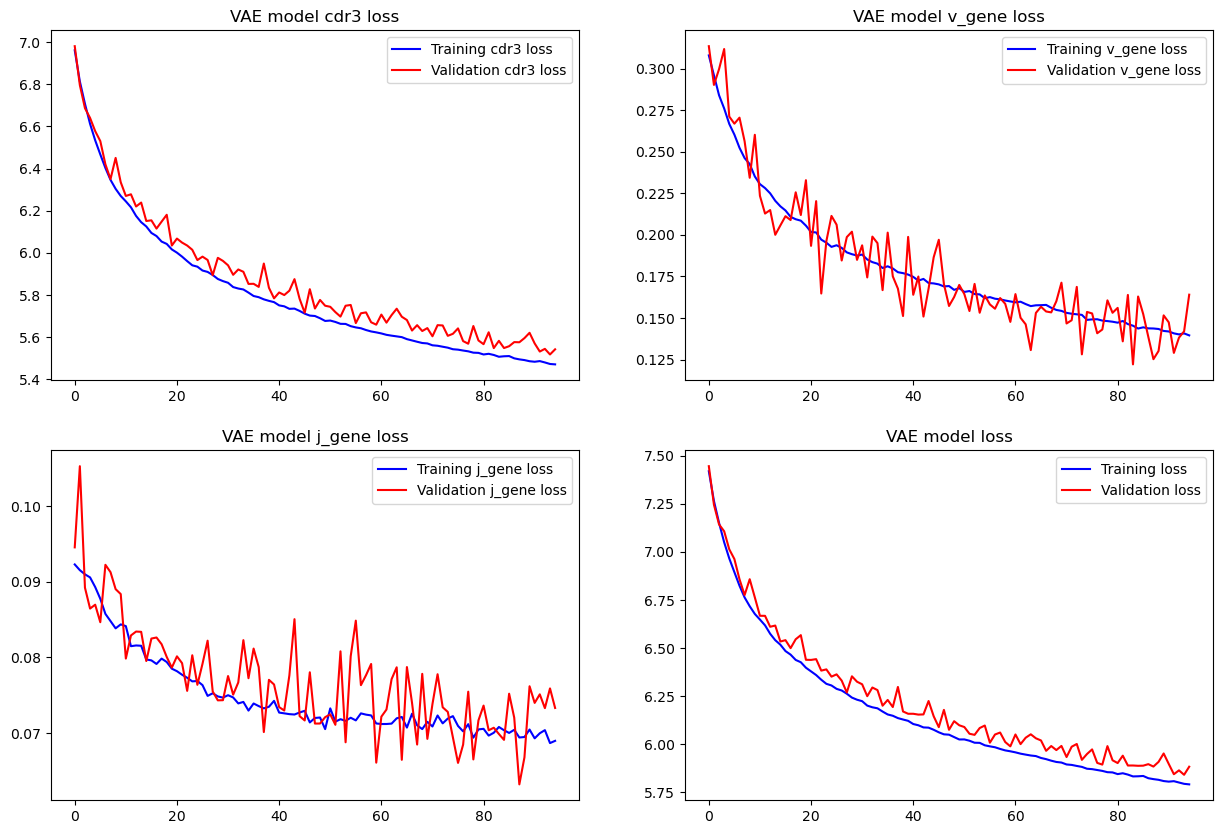

In [19]:
#Plot the history loss of the model with 4 subfigures
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['cdr3_output_loss'][5:], label='Training cdr3 loss', color='blue')
plt.plot(history.history['val_cdr3_output_loss'][5:], label='Validation cdr3 loss', color='red')
plt.title('VAE model cdr3 loss')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(history.history['v_gene_output_loss'][5:], label='Training v_gene loss', color='blue')
plt.plot(history.history['val_v_gene_output_loss'][5:], label='Validation v_gene loss', color='red')
plt.title('VAE model v_gene loss')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(history.history['j_gene_output_loss'][5:], label='Training j_gene loss', color='blue')
plt.plot(history.history['val_j_gene_output_loss'][5:], label='Validation j_gene loss', color='red')
plt.title('VAE model j_gene loss')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(history.history['loss'][5:], label='Training loss', color='blue')
plt.plot(history.history['val_loss'][5:], label='Validation loss', color='red')
plt.title('VAE model loss')
plt.legend()
plt.show()

In [21]:
# save weights 
res["vae"].save_weights("./models/vae_weights.h5")
res["encoder"].save_weights("./models/encoder_weights.h5")

#load weights
res["vae"].load_weights("./models/vae_weights.h5")


In [89]:
X_train_2[0].shape[0]

236000

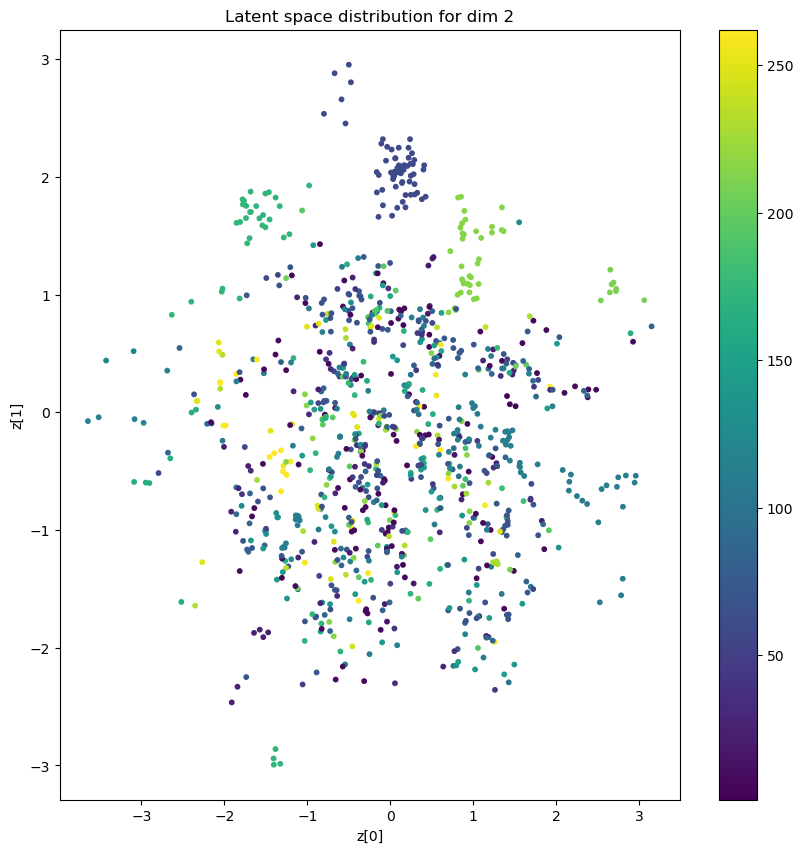

In [90]:
# Plot latent space distribution
# sample 1000 random sequences without replacement random choice
idx = np.random.choice(X_train_2[0].shape[0], 1000, replace=False)
z_mean, z_log_var = res["encoder"].predict([X_train_2[0][idx], X_train_2[1][idx], X_train_2[2][idx]])
# Convert the log variance to standard deviation
z_std = np.exp(0.5 * z_log_var)
# Sample from the latent space
z = z_mean + z_std * np.random.normal(size=z_mean.shape)

y_train = df['label'].values

# Plot the latent space distribution with colours for labels
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], s=10, c=y_train[idx])
plt.title(f"Latent space distribution for dim {params['latent_dim']}")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.show()


In [91]:
z.shape

(1000, 2)

In [92]:
# Display a grid of predicted CDR3s
#create grid between -3 and 3
store = []
scale = 4
n = 100
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = res["decoder"].predict(z_sample)
        cdr3 = x_decoded[0][0]
        v_gene = x_decoded[1][0]
        j_gene = x_decoded[2][0]
        #transform to amino acids
        cdr3 = np.argmax(cdr3, axis=-1)
        cdr3 = label_encoder.inverse_transform(cdr3)
        cdr3 = "".join(cdr3)
        store.append(cdr3)



In [93]:
values_store = []
for i, cdr3 in tqdm(enumerate(store)):
    sub = df[df['CDR3_al'] == cdr3]
    if sub.shape[0] > 0:
        values_store.append(int(sub['label'].values[0]))
    else: 
        values_store.append(300)
    


0it [00:00, ?it/s]

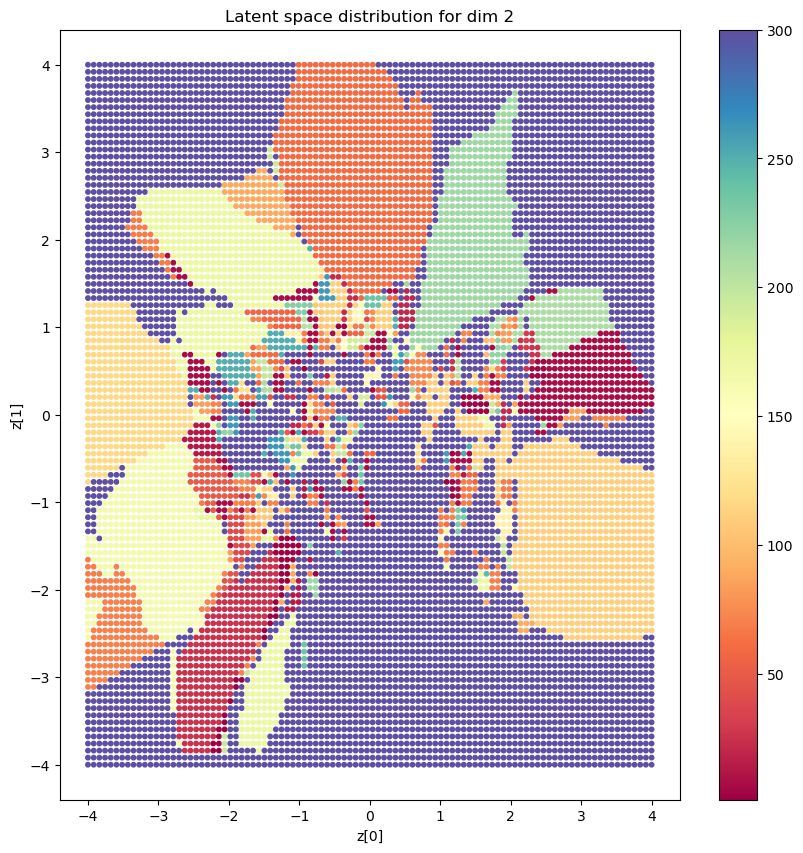

In [94]:
# Plot the grid of values 
plt.figure(figsize=(10, 10))
x, y = np.meshgrid(grid_x, grid_y)
plt.scatter(x,y, s=10, c=values_store, cmap='Spectral')
plt.title(f"Latent space distribution for dim {params['latent_dim']}")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.show()


Show effect of beta on different metrics (means, ...)
More latent dimensions ( with and whtout PCA)

In [74]:
# value counts for y_train
pd.Series(y_train).value_counts()[:15]

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_83057/674870841.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pd.Series(y_train).value_counts()[:15]


111    28785
60     16558
7      16446
172    14043
215    12759
68      9291
72      6291
8       6246
85      6191
142     6089
71      4298
250     3630
74      3164
262     3024
26      2842
dtype: int64

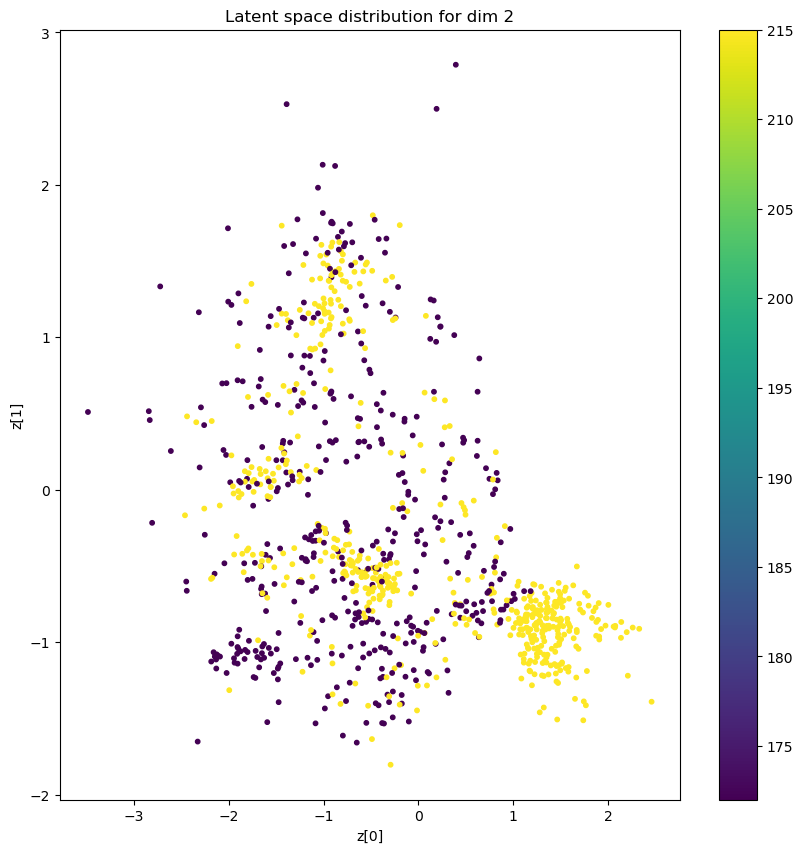

In [65]:
# Plot latent space distribution
# Keep only different sequences
X_train_3 = X_train_2.copy()
y_train_3 = y_train.copy()[:236000]
# get rid of duplicates sequences
vals, idx = np.unique(X_train_3[0], axis=0, return_index=True)
for i in range(len(X_train_3)):
    X_train_3[i] = X_train_3[i][idx]
y_train_3 = y_train_3[idx]
# Keep only two groups (7, 172)
idx_7 = np.where(y_train_3 == 215)[0]
idx_172 = np.where(y_train_3 == 172)[0]
idx = np.concatenate((idx_7, idx_172))
for i in range(len(X_train_3)):
    X_train_3[i] = X_train_3[i][idx]
y_train_3 = y_train_3[idx]
# sample 1000 random sequences without replacement random choice
idx_samples = np.random.choice(X_train_3[0].shape[0], 1000, replace=False)
for i in range(len(X_train_3)):
    X_train_3[i] = X_train_3[i][idx_samples]
samples = [X_train_3[0], X_train_3[1], X_train_3[2]]
# Predict the latent space
z_mean, z_log_var = res["encoder"].predict(samples)
# Convert the log variance to standard deviation
z_std = np.exp(0.5 * z_log_var)
# Sample from the latent space
z = z_mean + z_std * np.random.normal(size=z_mean.shape)

y_train = df['label'].values

# Plot the latent space distribution with colours for labels
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], s=10, c=y_train_3[idx_samples])
plt.title(f"Latent space distribution for dim {params['latent_dim']}")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.show()


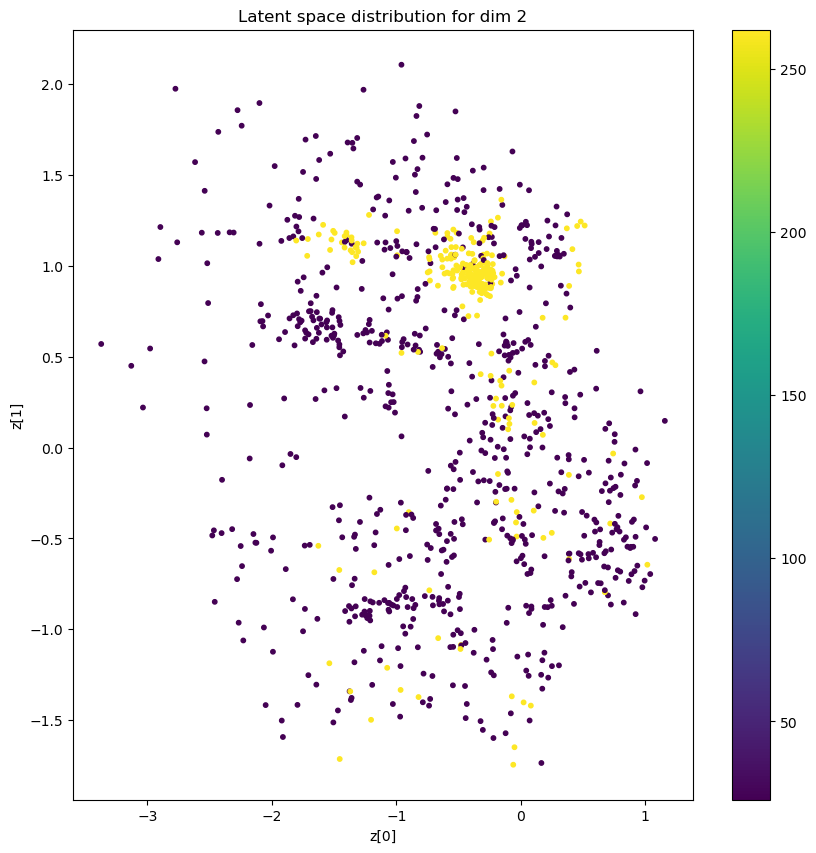

In [78]:
# Plot latent space distribution
# Keep only different sequences
X_train_3 = X_train_2.copy()
y_train_3 = y_train.copy()[:236000]
# get rid of duplicates sequences
vals, idx = np.unique(X_train_3[0], axis=0, return_index=True)
for i in range(len(X_train_3)):
    X_train_3[i] = X_train_3[i][idx]
y_train_3 = y_train_3[idx]
# Keep only two groups (7, 172)
idx_7 = np.where(y_train_3 == 26)[0]
idx_172 = np.where(y_train_3 == 262)[0]
idx = np.concatenate((idx_7, idx_172))
for i in range(len(X_train_3)):
    X_train_3[i] = X_train_3[i][idx]
y_train_3 = y_train_3[idx]
# sample 1000 random sequences without replacement random choice
idx_samples = np.random.choice(X_train_3[0].shape[0], 1000, replace=False)
for i in range(len(X_train_3)):
    X_train_3[i] = X_train_3[i][idx_samples]
samples = [X_train_3[0], X_train_3[1], X_train_3[2]]
# Predict the latent space
z_mean, z_log_var = res["encoder"].predict(samples)
# Convert the log variance to standard deviation
z_std = np.exp(0.5 * z_log_var)
# Sample from the latent space
z = z_mean + z_std * np.random.normal(size=z_mean.shape)

y_train = df['label'].values

# Plot the latent space distribution with colours for labels
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], s=10, c=y_train_3[idx_samples])
plt.title(f"Latent space distribution for dim {params['latent_dim']}")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.show()


In [23]:
# Assign numbner to each different cdr3 
unique_cdr3 = np.unique(store)
# Randomize order
np.random.shuffle(unique_cdr3)
unique_cdr3_dict = {}
for i, cdr3 in enumerate(unique_cdr3):
    unique_cdr3_dict[cdr3] = i

# create a list matching store
different_cdr3 = []
for i, cdr3 in enumerate(store):
    different_cdr3.append(unique_cdr3_dict[cdr3])

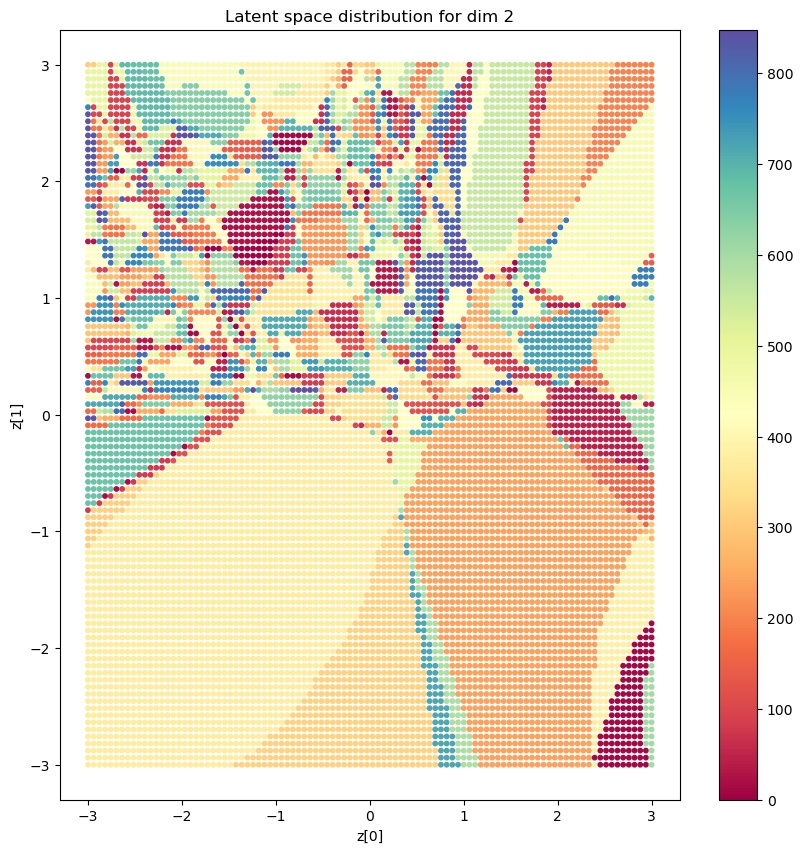

In [24]:
# Plot the grid of values 
plt.figure(figsize=(10, 10))
x, y = np.meshgrid(grid_x, grid_y)
plt.scatter(x,y, s=10, c=different_cdr3, cmap='Spectral')
plt.title(f"Latent space distribution for dim {params['latent_dim']}")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
plt.show()


Text(0, 0.5, 'z[1]')

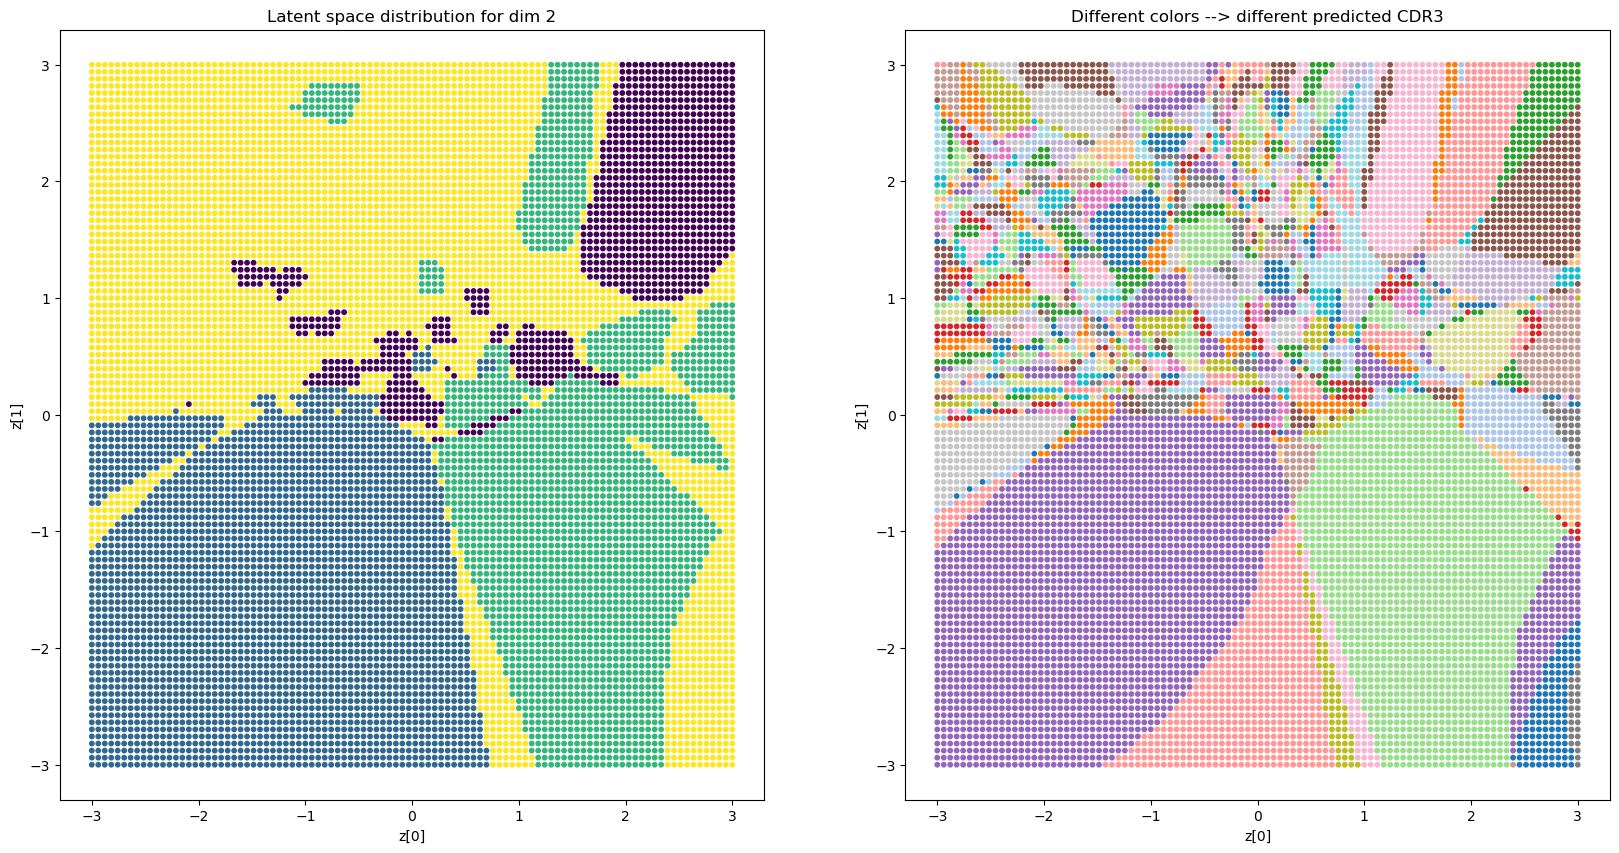

In [25]:
#Display both plots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the grid of values 
x, y = np.meshgrid(grid_x, grid_y)
ax1.scatter(x,y, s=10, c=values_store)
ax1.set_title(f"Latent space distribution for dim {params['latent_dim']}")
ax1.set_xlabel("z[0]")
ax1.set_ylabel("z[1]")

# Plot the grid of values
x, y = np.meshgrid(grid_x, grid_y)
ax2.scatter(x,y, s=10, c=different_cdr3, cmap='tab20')
ax2.set_title("Different colors --> different predicted CDR3")
ax2.set_xlabel("z[0]")
ax2.set_ylabel("z[1]")



In [39]:
# count appearance of each value in values_store
unique, counts = np.unique(values_store, return_counts=True)
dict(zip(unique, counts))

{0: 1005, 1: 2851, 2: 2249, 3: 3895}

In [57]:
# Measure homogeneity of each group 
for i in np.unique(values_store):
    # get index of each group
    idx = np.where(values_store == i)[0]
    # get list of sequences in each group
    seqs = [store[i] for i in idx]
    # get unique sequences
    unique_seqs = np.unique(seqs)
    print("=====================================")
    print(f"Group {i} has {len(unique_seqs)} unique sequences")
    # Get measure of homogeneity (number of unique sequences / total number of sequences)
    print(f"Group {i} is {round(len(unique_seqs)/len(seqs), 3)} heteregeneous")
    # get number of sequences in each group of each unique sequence
    for seq in unique_seqs:
        print(f"Sequence {seq} has {seqs.count(seq)} appearances")
    

    

Group 0 has 34 unique sequences
Group 0 is 0.034 heteregeneous
Sequence CASSG---------TGELFF has 1 appearances
Sequence CASSL---------GDTQYF has 8 appearances
Sequence CASSL---------GETQYF has 3 appearances
Sequence CASSL---------GGGYTF has 2 appearances
Sequence CASSL---------TDTQYF has 5 appearances
Sequence CASSL---------TETQYF has 1 appearances
Sequence CASSL--------GGDTQYF has 6 appearances
Sequence CASSL--------GGETQYF has 5 appearances
Sequence CASSL--------GGTEAFF has 28 appearances
Sequence CASSL--------GGYEQYF has 30 appearances
Sequence CASSL--------GNTEAFF has 14 appearances
Sequence CASSL--------GSYEQYF has 9 appearances
Sequence CASSL--------GYNEQFF has 2 appearances
Sequence CASSL--------RGYEQYF has 3 appearances
Sequence CASSL-------AGNTEAFF has 17 appearances
Sequence CASSL-------DRGYEQYF has 9 appearances
Sequence CASSL-------GGNQPQHF has 14 appearances
Sequence CASSL-------GGNTEAFF has 25 appearances
Sequence CASSL-------GGSYEQYF has 15 appearances
Sequence CASSL----

In [56]:
# example of very reccurent predicted seauence 

print("TOTAL LEN OF DATASET:", len(df))
print("=====================================")
print("Example: CASSI-------RSSYEQYF")
print("Number of appearances in predicted sequences: ", different_cdr3.count(unique_cdr3_dict["CASSI-------RSSYEQYF"]))
print("Number of appearances in original dataset: ",len(df[df["CDR3_al"] == "CASSI-------RSSYEQYF"]))
print("Percentage of appearances in original dataset: ",len(df[df["CDR3_al"] == "CASSI-------RSSYEQYF"])/ len(df))

print("=====================================")
print("Example: CASSL-------AGAYEQYF")
print("Number of appearances in predicted sequences: ",different_cdr3.count(unique_cdr3_dict["CASSL-------AGAYEQYF"]))
print("Number of appearances in original dataset: ",len(df[df["CDR3_al"] == "CASSL-------AGAYEQYF"]))
print("Percentage of appearances in original dataset: ",len(df[df["CDR3_al"] == "CASSL-------AGAYEQYF"])/ len(df))

TOTAL LEN OF DATASET: 47047
Example: CASSI-------RSSYEQYF
Number of appearances in predicted sequences:  2059
Number of appearances in original dataset:  13224
Percentage of appearances in original dataset:  0.2810806215061534
Example: CASSL-------AGAYEQYF
Number of appearances in predicted sequences:  1434
Number of appearances in original dataset:  7735
Percentage of appearances in original dataset:  0.1644100580270793


In [ ]:
# Check how to change the number of means --> Can we really ?? No params for number of means... --> check mathematical formulation: to do
# Check with larger dataset the number of means 
# Try to visualize the distributions as heatmap 
# Generate new sequences using decoded sequences and use them to build heatmap 
# CHeck the mean correspond to the one of the VAE --> Can I do that ?? 


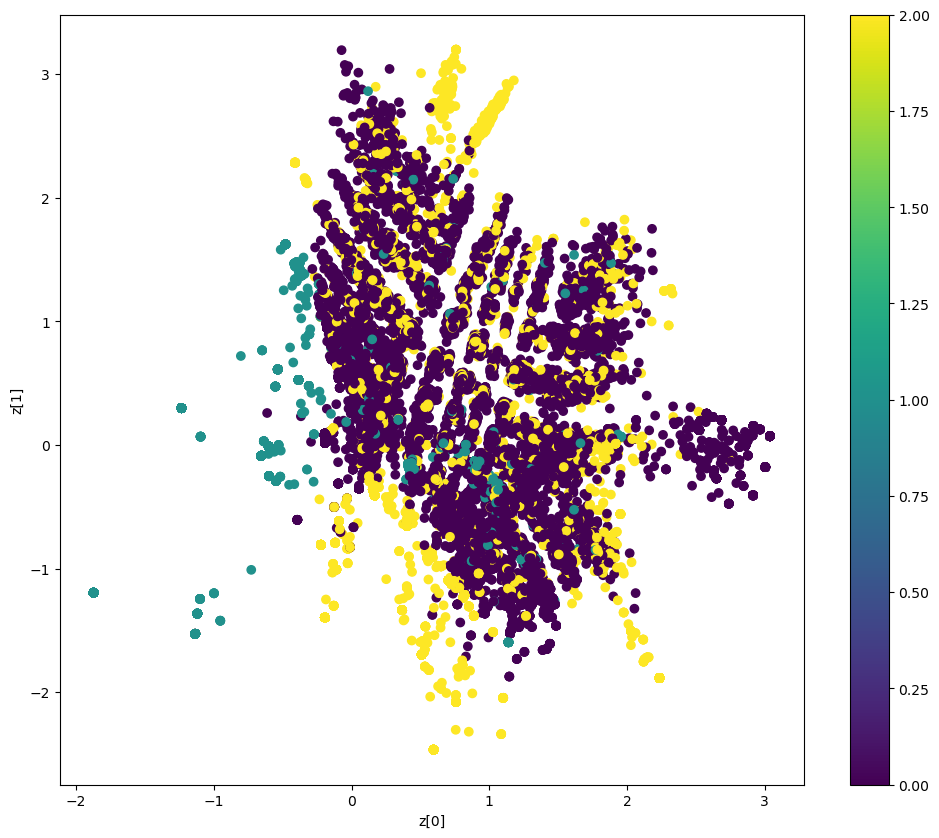

In [23]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _ = vae["encoder"].predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_label_clusters(res, X_train_2, y_train[:47000])

  0%|          | 0/47047 [00:00<?, ?it/s]

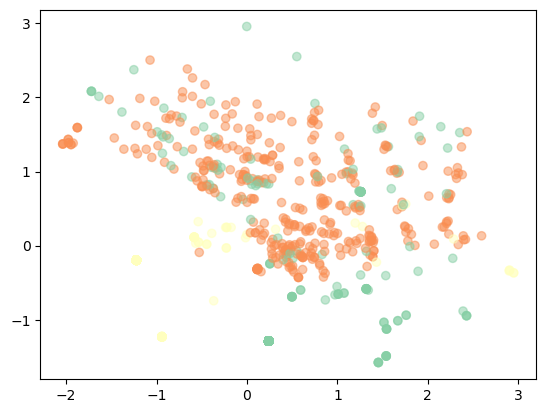

Accuracy:  0.768


/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_95382/3695709343.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_


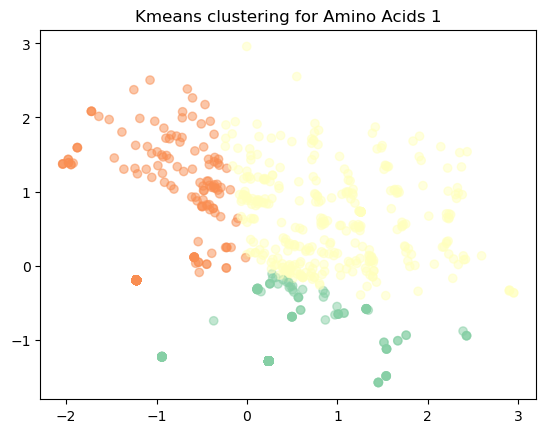

In [134]:
label = "Amino Acids 1"
labels = []
labels_encoder = LabelEncoder()
labels_encoder = labels_encoder.fit(df[label].unique())
for k in tqdm(df.index):
    labels.append(labels_encoder.transform([df.loc[k,label]]))
labels = [int(y) for y in labels]
df[label] = labels
rgb_values = sns.color_palette("Spectral", df[label].nunique())
df[str(label+"_color")] = df[label].apply(lambda x: rgb_values[x])

N=1000
X_test = X_train.copy()
for i in range(len(X_test)):
    X_test[i] = X_test[i][:N]

X_test_encode = res["encoder"].predict(X_test)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_test_encode[0])
plot_X_test = principalComponents

plt.scatter(plot_X_test[:,0], plot_X_test[:,1], color=df[str(label+"_color")][:N], alpha=0.5)
plt.show()

k = 3
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_test_encode[0][:N])
labels = pd.Series(kmeans.labels_)
rgb_values = sns.color_palette("Spectral", k)
col_kmeans = labels.apply(lambda x: rgb_values[x])
sample = df[:N]
sample[str(label+"_kmeans_label")] = kmeans.labels_
label_dict = {}
for cluster in range(k):
    label_ind = sample[sample[str(label+"_kmeans_label")] == cluster][label].value_counts().index[0]
    label_dict[cluster] = label_ind

print("Accuracy: ", sum([label_dict[x] == y for x,y in zip(sample[str(label+"_kmeans_label")], sample[label])])/len(sample))
plt.scatter(plot_X_test[:,0], plot_X_test[:,1], color=col_kmeans, alpha=0.5)
centroids = kmeans.cluster_centers_
plt.title("Kmeans clustering for "+label)
plt.show()

  0%|          | 0/47047 [00:00<?, ?it/s]

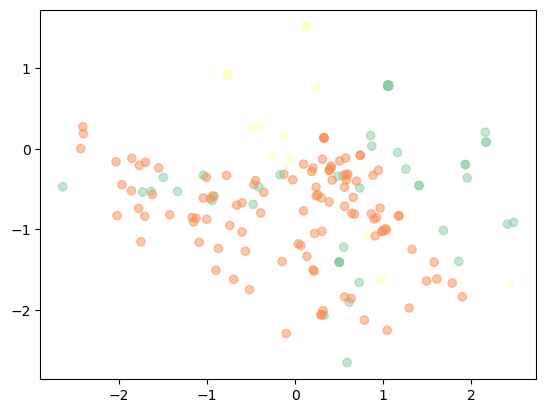

0    300
dtype: int64


IndexError: list index out of range

In [133]:
label = "Amino Acids 1"
labels = []
labels_encoder = LabelEncoder()
labels_encoder = labels_encoder.fit(df[label].unique())
for k in tqdm(df.index):
    labels.append(labels_encoder.transform([df.loc[k,label]]))
labels = [int(y) for y in labels]
df[label] = labels
rgb_values = sns.color_palette("Spectral", df[label].nunique())
df[str(label+"_color")] = df[label].apply(lambda x: rgb_values[x])

N=300
X_test = X_train.copy()
for i in range(len(X_test)):
    X_test[i] = X_test[i][:N]

X_test_encode = res["encoder"].predict(X_test)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_test_encode[0])
plot_X_test = X_test_encode[0]

plt.scatter(plot_X_test[:,0], plot_X_test[:,1], color=df[str(label+"_color")][:N], alpha=0.5)
plt.show()

dbscan = DBSCAN(eps=1, min_samples=5).fit(X_test_encode[0][:N])
labels = pd.Series(dbscan.labels_)
k = len(set(labels))-1
print(labels.value_counts())
rgb_values = sns.color_palette("Spectral", k)
col_dbscan = labels.apply(lambda x: rgb_values[x])
sample = df[:N]
sample[str(label+"_dbscan_label")] = dbscan.labels_
label_dict = {}
label_dict[-1] = -1
for cluster in range(k):
    label_ind = sample[sample[str(label+"_dbscan_label")] == cluster][label].value_counts().index[0]
    label_dict[cluster] = label_ind

print("Accuracy: ", sum([label_dict[x] == y for x,y in zip(sample[str(label+"_dbscan_label")], sample[label])])/len(sample))
plt.scatter(plot_X_test[:,0], plot_X_test[:,1], color=col_dbscan, alpha=0.5)
plt.title("DBSCAN clustering for "+label)
plt.show()


  0%|          | 0/47047 [00:00<?, ?it/s]

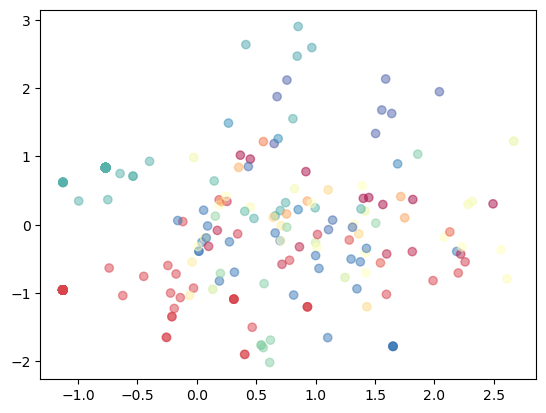

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Accuracy:  0.32666666666666666
Accuracy:  0.3933333333333333
Accuracy:  0.6066666666666667


/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Accuracy:  0.6133333333333333
Accuracy:  0.5866666666666667
Accuracy:  0.6133333333333333


/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Accuracy:  0.62
Accuracy:  0.6466666666666666
Accuracy:  0.6433333333333333


/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Accuracy:  0.63
Accuracy:  0.64
Accuracy:  0.6466666666666666


/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_


Accuracy:  0.67
Accuracy:  0.68


/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_


Accuracy:  0.69
Accuracy:  0.6966666666666667


/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_


Accuracy:  0.72
Accuracy:  0.6966666666666667


/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_


Accuracy:  0.7
Accuracy:  0.6933333333333334
Optimal k:  17
Highest accuracy:  0.72


/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_81984/2198257169.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_


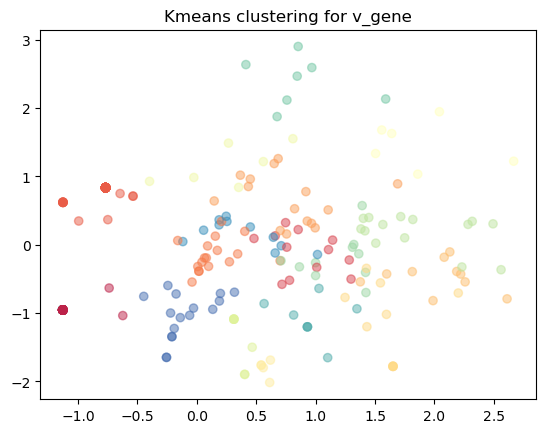

In [ ]:
label = "v_gene"
#df[label] = df["j_gene"].apply(lambda x: x.split("-")[0])
labels = []
labels_encoder = LabelEncoder()
labels_encoder = labels_encoder.fit(df[label].unique())
for k in tqdm(df.index):
    labels.append(labels_encoder.transform([df.loc[k,label]]))
labels = [int(y) for y in labels]
df[label] = labels
rgb_values = sns.color_palette("Spectral", df[label].nunique())
df[str(label+"_color")] = df[label].apply(lambda x: rgb_values[x])

N=300
X_test = X_train.copy()
for i in range(len(X_test)):
    X_test[i] = X_test[i][:N]

X_test_encode = res["encoder"].predict(X_test)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_test_encode[0])
plot_X_test = principalComponents

plt.scatter(plot_X_test[:,0], plot_X_test[:,1], color=df[str(label+"_color")][:N], alpha=0.5)
plt.show()

highest_k = 1
highest_accuracy = 0
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X_test_encode[0][:N])
    labels = pd.Series(kmeans.labels_)
    rgb_values = sns.color_palette("Spectral", k)
    col_kmeans = labels.apply(lambda x: rgb_values[x])
    sample = df[:N]
    sample[str(label+"_kmeans_label")] = kmeans.labels_
    label_dict = {}
    for cluster in range(k):
        label_ind = sample[sample[str(label+"_kmeans_label")] == cluster][label].value_counts().index[0]
        label_dict[cluster] = label_ind
    accuracy = sum([label_dict[x] == y for x,y in zip(sample[str(label+"_kmeans_label")], sample[label])])/len(sample)
    print("Accuracy: ", accuracy)
    if accuracy > highest_accuracy:
        highest_accuracy = accuracy
        highest_k = k

kmeans = KMeans(n_clusters=highest_k, random_state=0, n_init=10).fit(X_test_encode[0][:N])
labels = pd.Series(kmeans.labels_)
rgb_values = sns.color_palette("Spectral", highest_k)
col_kmeans = labels.apply(lambda x: rgb_values[x])
sample = df[:N]
sample[str(label+"_kmeans_label")] = kmeans.labels_
label_dict = {}
for cluster in range(highest_k):
    label_ind = sample[sample[str(label+"_kmeans_label")] == cluster][label].value_counts().index[0]
    label_dict[cluster] = label_ind
print("Optimal k: ", highest_k)
print("Highest accuracy: ", sum([label_dict[x] == y for x,y in zip(sample[str(label+"_kmeans_label")], sample[label])])/len(sample))
plt.scatter(plot_X_test[:,0], plot_X_test[:,1], color=col_kmeans, alpha=0.5)
centroids = kmeans.cluster_centers_
plt.title("Kmeans clustering for "+label)
plt.show()